# Willman 1: Mass segregation analysis

Import necessary packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None #overwriting values in df without warnings
pd.set_option('display.max_columns', None) #display whole table in line
pd.set_option('display.max_rows', None)

import numpy as np
import astropy

from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import scipy
import sfdmap
from wil1_properties import ra_w1, dec_w1, aax, bax, r_half, alpha, ecc, dist
import membership_utils

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

### Open data

In [3]:
# open hst data
wil1_hst_dat = astropy.io.ascii.read('data/wil1_flagged08Jun.dat')  #hst analyzed data
hst_tot = wil1_hst_dat.to_pandas()

In [4]:
# convert to VEGAMAG 
vega_offset_606 = 26.658 - 26.395 # stmag zeropoint minus vega zeropoint
vega_offset_814 = 26.773 - 25.509

hst_tot["VEGA_606"] = hst_tot["STMAG_606"] - vega_offset_606
hst_tot["VEGA_814"] = hst_tot["STMAG_814"] - vega_offset_814

# convert to delta ra cos dec, delta dec
hst_tot["delta_ra_cosdec"] = (hst_tot["RA_606"] - ra_w1) * np.cos(np.deg2rad(dec_w1))
hst_tot["delta_dec"] = (hst_tot["DEC_606"] - dec_w1)

Spatial distribution

In [5]:
# empty columns
hst_tot["radius"]         = np.nan      # distance to center of Wil1 [deg]
hst_tot["radius_ell"]     = np.nan      # distance to center, calculated from elliptical radii [deg]
hst_tot["hl_radius_circ"] = np.nan      # distance to center of Wil1 [half-light radii]
hst_tot["hl_radius_ell"]  = np.nan      # half-light elliptical radius
hst_tot["r_proj"]         = np.nan      # projected half-light radius
hst_tot["pos_angle"]      = np.nan      # position angle (deg)

# calculate spatial properties for each star
for index, row in hst_tot.iterrows():
    radius, ell_radius, hl_radius_circular, hl_radius_elliptical, proj_distance, p_angle = \
        membership_utils.spatial_prop(row["delta_ra_cosdec"], row["delta_dec"], 0, 0, r_half, -alpha, aax, ecc)
    
    hst_tot.loc[index, "radius"]         = radius
    hst_tot.loc[index, "radius_ell"]     = ell_radius
    hst_tot.loc[index, "hl_radius_circ"] = hl_radius_circular
    hst_tot.loc[index, "hl_radius_ell"]  = hl_radius_elliptical
    hst_tot.loc[index, "r_proj"]         = proj_distance
    hst_tot.loc[index, "pos_angle"]      = p_angle

(-0.1, 0.1)

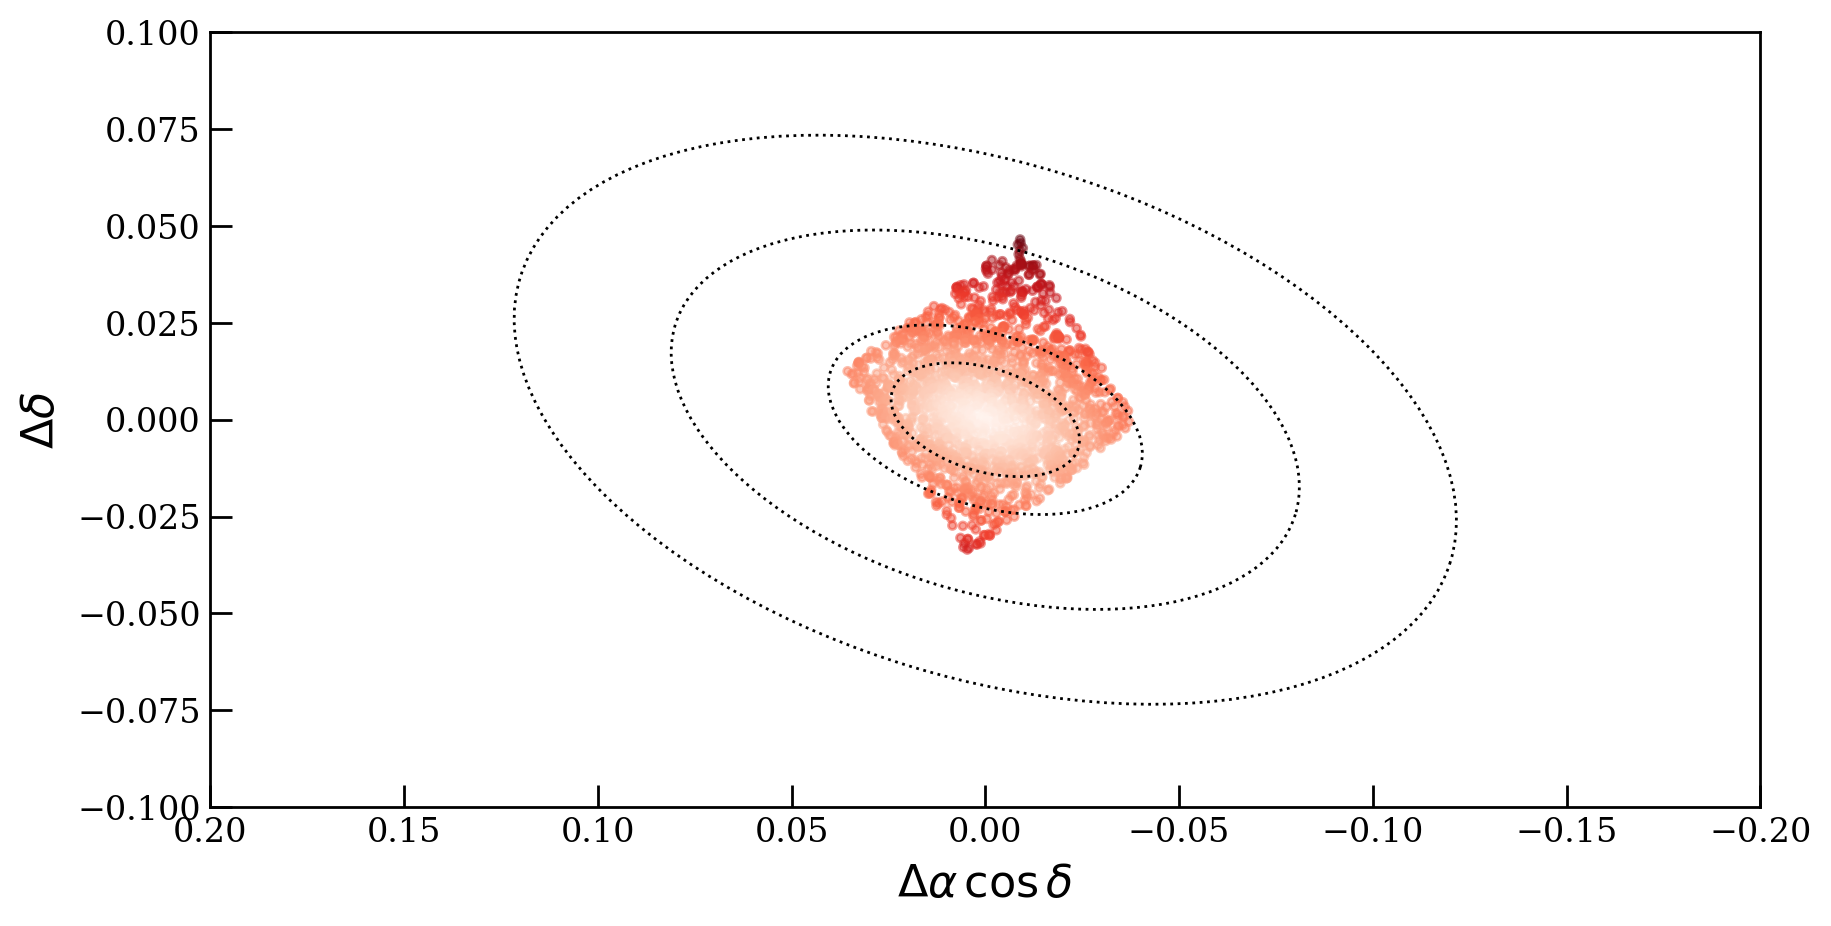

In [6]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
ax.set_aspect('equal', adjustable='box')

ax.scatter(hst_tot["delta_ra_cosdec"], hst_tot["delta_dec"], c = hst_tot["hl_radius_ell"], cmap = "Reds", alpha = 0.5, s = 8)

# half-light radii
for ii in [0.6, 1, 2, 3]:
    jj = 2 * ii
    ellipse = Ellipse((0, 0), bax * jj, aax * jj, angle = 360-73, fill = False, linestyle = ":", edgecolor = "black")
    ax.add_patch(ellipse)

ax.set_xlabel(r"$\Delta \alpha \, \cos \delta$", labelpad = 5, size = 16).set_color('black')
ax.set_ylabel(r"$\Delta \delta$", labelpad = 5, size = 16).set_color('black')

ax.set_xlim(0.2, -0.2)
ax.set_ylim(-0.1, 0.1)

#fig.savefig("wil1_spatial_ellipse_hst.pdf", dpi = 600, transparent = True)

### Isochrone fitting

In [7]:
#Extinction/reddening
m = sfdmap.SFDMap("data/sfddata-master")
EBV = m.ebv(ra_w1, dec_w1)

A_606 = EBV * 0.924 # extinction coefficient for WFC/F606W
A_814 = EBV * 0.602 # extinction coefficient for WFC/F814W

A_606, A_814

(0.01089029379209043, 0.00709519140999831)

In [8]:
# isochrone data
mist_iso = astropy.io.ascii.read("data/isochrones/MIST_v1.2_feh_m2.10_afe_p0.0_vvcrit0.4_HSTWFC.iso.cmd") # [Fe/H] = -2.1

iso_mag_606_814 = np.asarray(mist_iso["ACS_WFC_F606W"] - mist_iso['ACS_WFC_F814W'] + A_606 - A_814) + 0.08
iso_mag_814 = np.asarray(mist_iso['ACS_WFC_F814W'] + 5.*np.log10(dist*1e3) - 5. + A_814) + 0.2
iso_mass = np.asarray(mist_iso['star_mass'])

mist_iso_data = pd.DataFrame({"mag": iso_mag_814, "color": iso_mag_606_814, "mass": iso_mass})     # convert isochrone data to pandas df
mist_iso_data = mist_iso_data[:250]

In [9]:
# isochrone data
parsec_iso = astropy.io.ascii.read("data/isochrones/parsec_hst_isochrone.txt") # [Fe/H] = -2.1

iso_mag_606_814 = np.asarray(parsec_iso["F606Wmag"] - parsec_iso['F814Wmag'] + A_606 - A_814)
iso_mag_814 = np.asarray(parsec_iso['F814Wmag'] + 5.*np.log10(dist*1e3) - 5. + A_814)
iso_mass = np.asarray(parsec_iso['Mini'])

parsec_iso_data = pd.DataFrame({"mag": iso_mag_814, "color": iso_mag_606_814, "mass": iso_mass})     # convert isochrone data to pandas df
parsec_iso_data = parsec_iso_data[:200]

(29.0, 19.0)

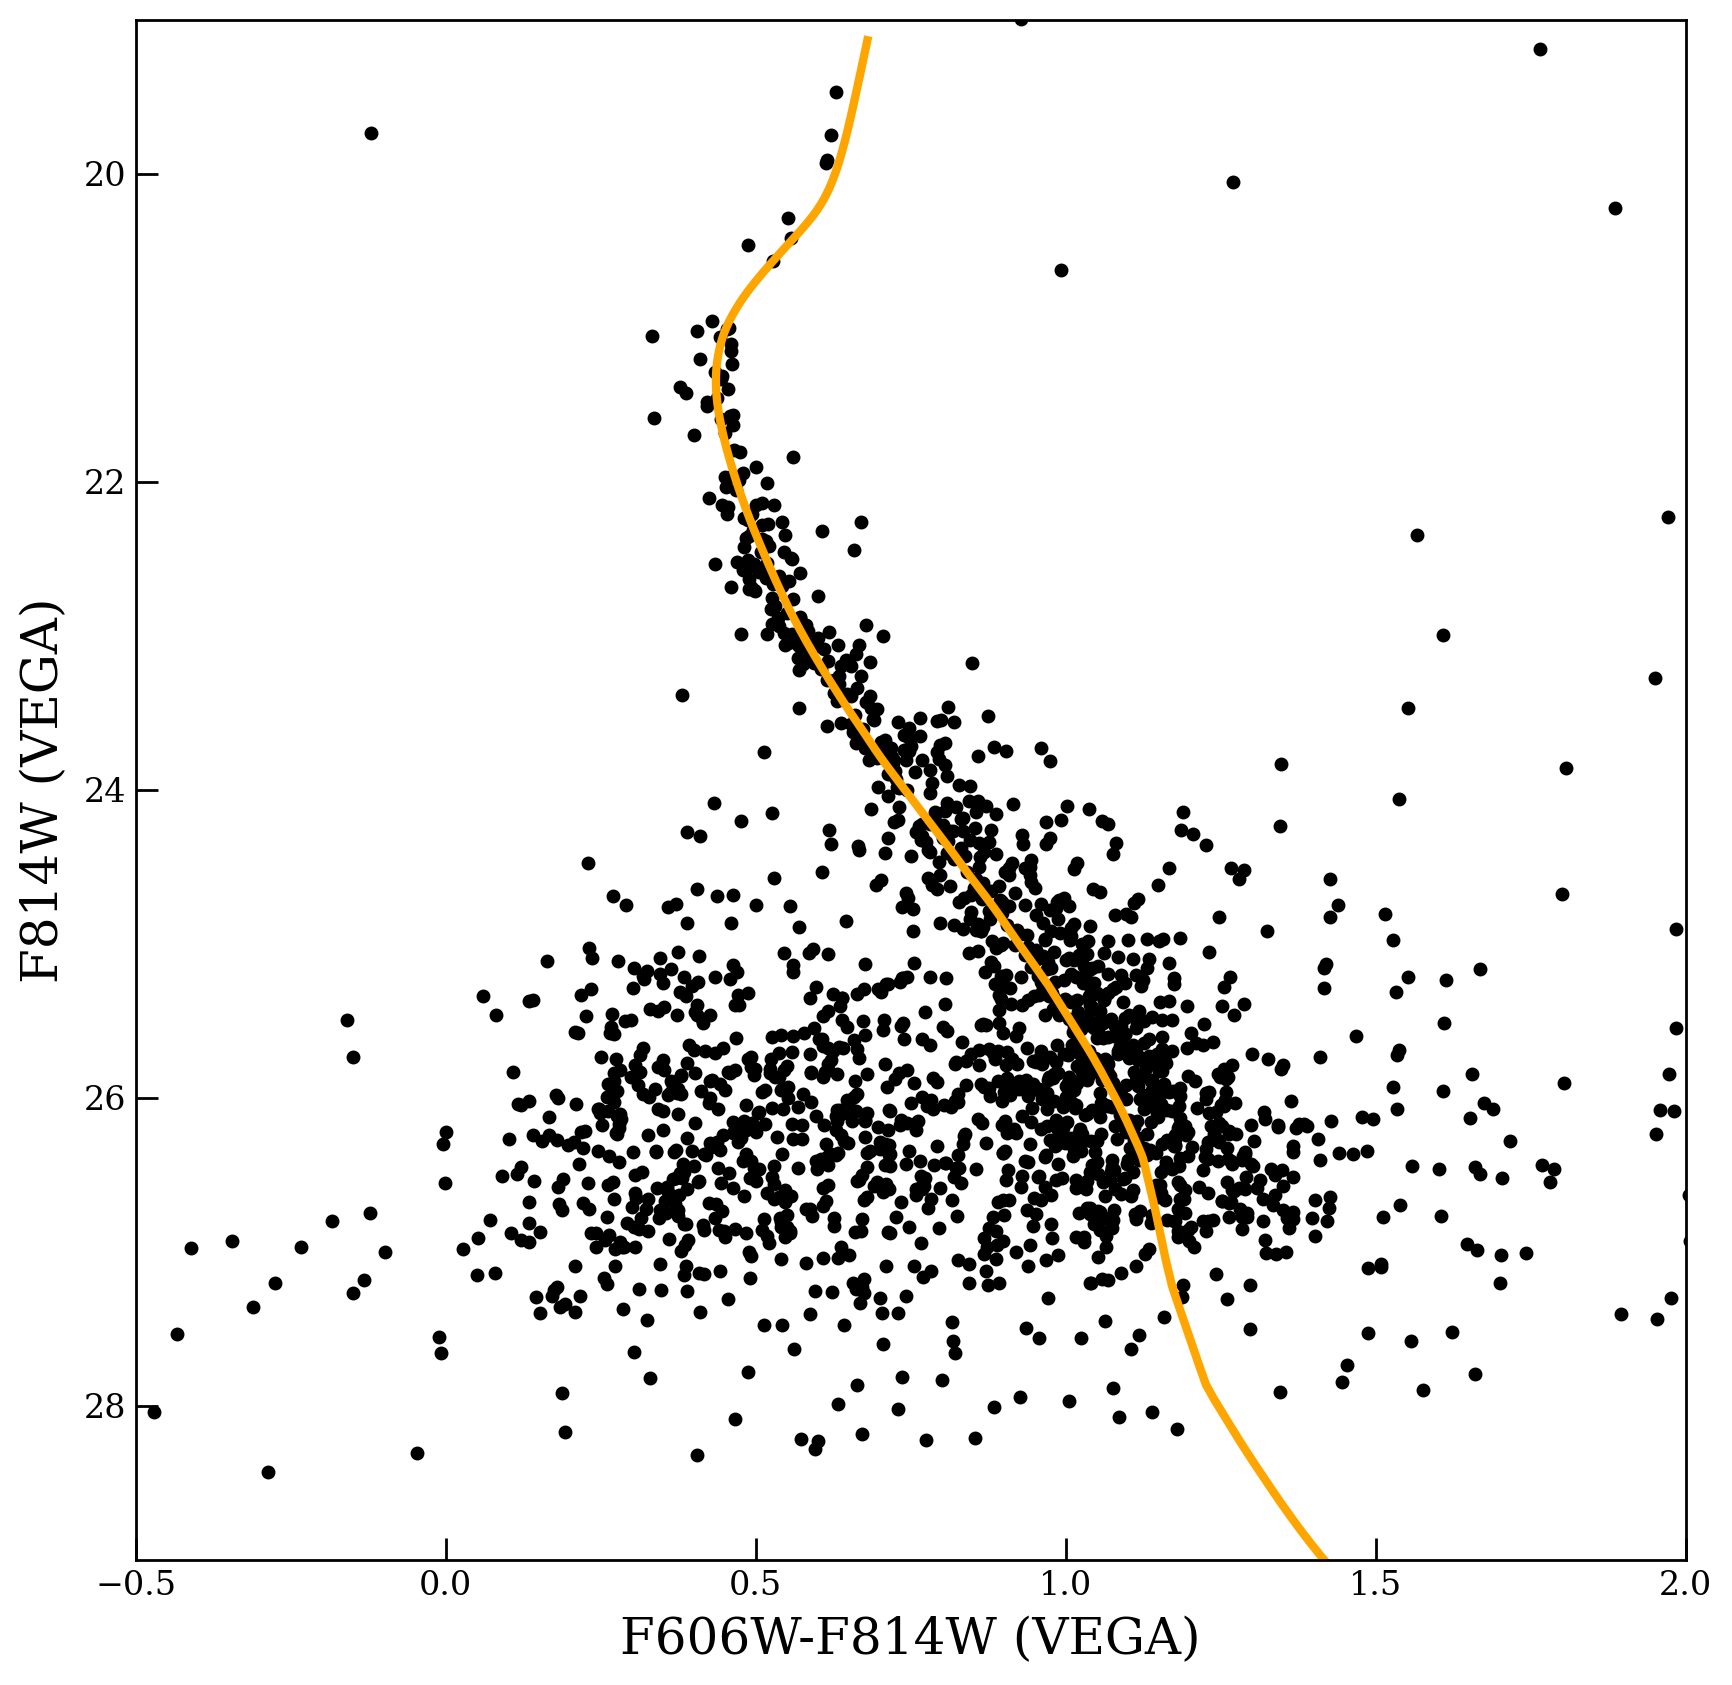

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

ax.plot(mist_iso_data["color"], mist_iso_data["mag"], linewidth = 3, c = "orange", label = "MIST Isochrone: 12 Gyr, 38 kpc, [Fe/H] = -2") #iso

ax.scatter(hst_tot["VEGA_606"] - hst_tot["VEGA_814"], hst_tot["VEGA_814"], c = "black", s = 16) #full data

ax.set_xlabel("F606W-F814W (VEGA)", labelpad = 5, size = 18).set_color('black')
ax.set_ylabel("F814W (VEGA)", labelpad = 5, size = 18).set_color('black')

ax.set_xlim(-0.5, 2)
ax.set_ylim(29, 19)

In [11]:
hst_tot["perp_dist_iso"] = np.nan   #empty column for perpendicular distance
hst_tot["cmd_marker"] = np.nan      #empty column for cmd marker

# adding mag errors
for index_hst, row_hst in hst_tot.iterrows():
    # color-magnitude DEIMOS data + errors
    mag = hst_tot.loc[index_hst, "VEGA_814"]
    color = hst_tot.loc[index_hst, "VEGA_606"] - mag
    color_err = (hst_tot.loc[index_hst, "ERR_606"] ** 2 + hst_tot.loc[index_hst, "ERR_814"] ** 2) ** (1/2)
    
    # calculate distance from star's cmd location to each point in isochrone    
    iso_dists = np.sqrt((mag - mist_iso_data["mag"]) ** 2 + (color - mist_iso_data["color"])**2)
    d_min = np.min(iso_dists)
    hst_tot.loc[index_hst, "perp_dist_iso"] = d_min    
    
    # calculate probability from perpendicular distance
    if 2 * color_err > 0.15:
        perp_dist_err = 2 * color_err
    else:
        perp_dist_err = 0.15
    
    if d_min <= perp_dist_err:
        hst_tot.loc[index_hst, "cmd_marker"] = 1
    
    else:
        hst_tot.loc[index_hst, "cmd_marker"] = 0

### Mass segregation analysis

In [12]:
hst_wil1_cut = hst_tot[(hst_tot["hl_radius_ell"] <= 1) & (hst_tot["cmd_marker"] == 1) & (hst_tot["sgXFlag"] >= 0.7)]
len(hst_wil1_cut)

635

In [13]:
ms_turnoff = 21.25
phys_cutoff = np.max(mist_iso_data[mist_iso_data["mass"] >= 0.5]["mag"]) # 1/2 solar mass stars
comp_50 = 26.9
comp_90 = 26.2

In [14]:
def create_samples(lower_bound):
    #cut data
    mask2 = (hst_wil1_cut["cmd_marker"] == 1) & (hst_wil1_cut["hl_radius_ell"] <= 1) & (hst_tot["sgXFlag"] >= 0.7)
    hst_mems = hst_wil1_cut[mask2]
    
    mask3 = (hst_mems["VEGA_814"] > ms_turnoff) & (hst_mems["VEGA_814"] < lower_bound)
    hst_cut = hst_mems[mask3]

    sort_wil1_mag = np.sort(hst_cut["VEGA_814"]) # sort by magnitude
    mag_index = int((len(sort_wil1_mag)) / 2)    # find middle index
    mag_cutoff = sort_wil1_mag[mag_index]        # find mag cut off

    bright_mem = hst_cut[hst_cut["VEGA_814"] < mag_cutoff]
    faint_mem = hst_cut[hst_cut["VEGA_814"] >= mag_cutoff]
    
    return hst_mems, bright_mem, faint_mem, mag_cutoff

In [15]:
hst_mems, bright_mem1, faint_mem1, mag_cutoff1 = create_samples(phys_cutoff)
hst_mems, bright_mem2, faint_mem2, mag_cutoff2 = create_samples(comp_50)

len(bright_mem1), len(faint_mem1), len(bright_mem2), len(faint_mem2)

/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_12285/3549149107.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hst_mems = hst_wil1_cut[mask2]
/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_12285/3549149107.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hst_mems = hst_wil1_cut[mask2]


(113, 114, 296, 296)

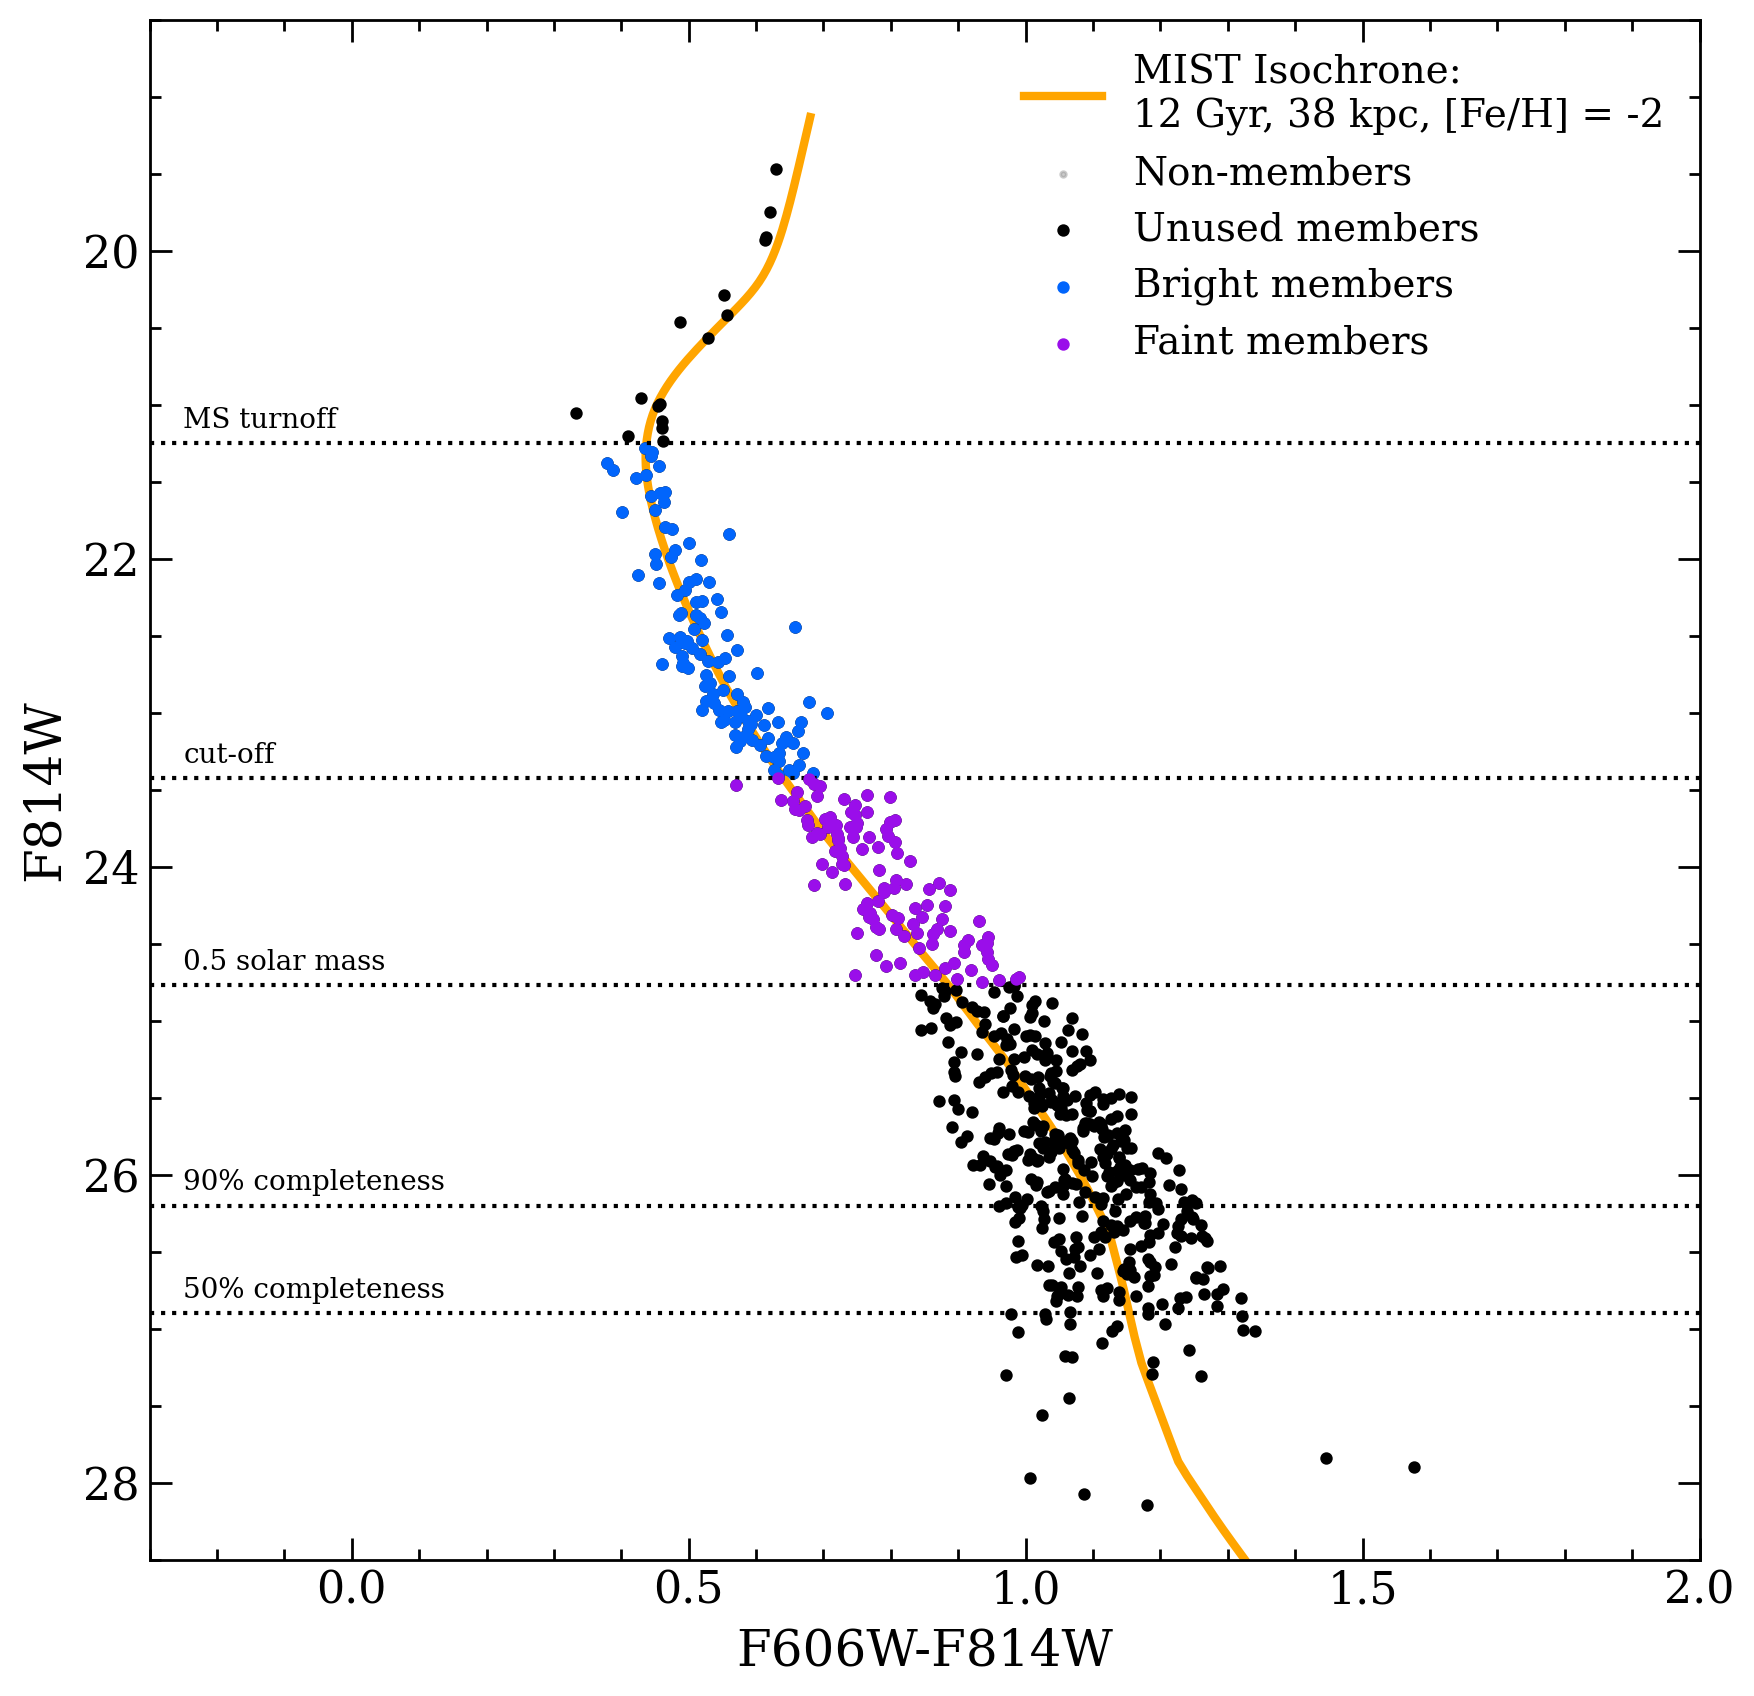

In [16]:
#CMD plot
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

ax.plot(mist_iso_data["color"], mist_iso_data["mag"], linewidth = 3, c = "orange", zorder = 0, label = "MIST Isochrone: \n12 Gyr, 38 kpc, [Fe/H] = -2") #iso

ax.scatter(hst_wil1_cut["VEGA_606"]-hst_wil1_cut["VEGA_814"], hst_wil1_cut["VEGA_814"], alpha = 0.5, c = "#999999", s = 4, zorder = 0, label = "Non-members") #full data
ax.scatter(hst_mems["VEGA_606"]-hst_mems["VEGA_814"], hst_mems["VEGA_814"], c = "black", s = 12, zorder = 1, label = "Unused members") #full wil1 data
ax.scatter(bright_mem1["VEGA_606"]-bright_mem1["VEGA_814"], bright_mem1["VEGA_814"], c = "#0165fc", s = 12, zorder = 2, label = "Bright members") #full data
ax.scatter(faint_mem1["VEGA_606"]-faint_mem1["VEGA_814"], faint_mem1["VEGA_814"], c = "#9a0eea", s = 12, zorder = 3, label = "Faint members") #full data

ax.axhline(ms_turnoff, linestyle = ":", c = "black")
ax.text(-0.25, ms_turnoff-0.1, 'MS turnoff')

ax.axhline(mag_cutoff1, linestyle = ":", c = "black")
ax.text(-0.25, mag_cutoff1-0.1, 'cut-off')

ax.axhline(phys_cutoff, linestyle = ":", c = "black")
ax.text(-0.25, phys_cutoff-0.1, '0.5 solar mass')

ax.axhline(comp_50, linestyle = ":", c = "black")
ax.text(-0.25, comp_50-0.1, '50% completeness')

ax.axhline(comp_90, linestyle = ":", c = "black")
ax.text(-0.25, comp_90-0.1, '90% completeness')

ax.set_xlabel("F606W-F814W", labelpad = 5, size = 18).set_color('black')
ax.set_ylabel("F814W", labelpad = 5, size = 18).set_color('black')

ax.set_xticks(np.arange(-0.5, 2.5, 0.5), minor = False)
ax.set_xticks(np.arange(-0.7, 2.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 16, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(18, 32, 2), minor = False)
ax.set_yticks(np.arange(18, 29.5, 0.5), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 16, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.set_xlim(-0.3, 2)
ax.set_ylim(28.5, 18.5)

ax.legend(loc = 'upper right', fontsize = 14, frameon = False)

#fig.savefig("hst_cmd_cut.pdf", dpi = 600, transparent = True)

In [17]:
#New dataframe to combine 
mass_seg_df = pd.DataFrame()
mass_seg_df["r_half"] = np.arange(0.05, 1.05, 0.05)
mass_seg_df["bright_percent"] = np.nan
mass_seg_df["faint_percent"] = np.nan

for i in range(len(mass_seg_df)):
    #maximum elliptical radius
    r_max = mass_seg_df.loc[i, "r_half"]
    #calculate num of stars within r_max
    sample = bright_mem1[bright_mem1["hl_radius_ell"] <= r_max]
    #calculate fraction of stars within r_max
    mass_seg_df.loc[i, "bright_percent"] = (len(sample) / len(bright_mem1))
    
for i in range(len(mass_seg_df)):
    #maximum elliptical radius
    r_max = mass_seg_df.loc[i, "r_half"]
    #calculate num of stars within r_max
    sample = faint_mem1[faint_mem1["hl_radius_ell"] <= r_max]
    #calculate fraction of stars within r_max
    mass_seg_df.loc[i, "faint_percent"] = (len(sample) / len(faint_mem1))

In [18]:
def calculate_hlradius(data):
    sort_data = np.sort(data["hl_radius_ell"])
    if (len(sort_data) % 2) == 0:
        #calculate indexes
        upper_index = int(len(sort_data) / 2)
        lower_index = upper_index - 1
        #calculate half-light elliptical radius
        half_light_radius = (sort_data[lower_index] + sort_data[upper_index]) / 2
        
    elif (len(sort_data) % 2) == 1:
        #calculate index
        middle_index = int((len(sort_data) - 1) / 2)
        #calculate half-light elliptical radius
        half_light_radius = sort_data[middle_index]
    
    return half_light_radius

In [19]:
faint_radius = calculate_hlradius(faint_mem1)
bright_radius = calculate_hlradius(bright_mem1)
print(faint_radius, bright_radius, bright_radius / faint_radius)

0.48476907287741255 0.5048679745599931 1.0414607754642449


In [20]:
scipy.stats.ks_2samp(bright_mem1["hl_radius_ell"], faint_mem1["hl_radius_ell"])

KstestResult(statistic=0.08523521192361434, pvalue=0.7530614903482579, statistic_location=0.5982633806160177, statistic_sign=1)

In [21]:
scipy.stats.ks_2samp(mass_seg_df["bright_percent"], mass_seg_df["faint_percent"])

KstestResult(statistic=0.1, pvalue=0.9999923931635496, statistic_location=0.008849557522123894, statistic_sign=1)

### Bootstrapping mass segregation analysis

In [22]:
def mass_seg_boot(bright_mem, faint_mem):
    bootstrap_df = pd.DataFrame([])
    bootstrap_df["r_half"] = np.arange(0.05, 1.05, 0.05)
    bootstrap_df["bright_percent"] = [list() for x in range(len(bootstrap_df.index))]
    bootstrap_df["faint_percent"] = [list() for x in range(len(bootstrap_df.index))]

    bright_hlr = []
    faint_hlr = []
    ratio = []

    numf = len(faint_mem)
    numb = len(bright_mem)
    num = int((numf + numb) / 2)
    
    #
    for i in range(num):
        #create faint sample
        faint_index_list = np.random.choice(numf-1, numf)
        bootstrap_faint_sample = faint_mem.iloc[faint_index_list]
    
        #create bright sample
        bright_index_list = np.random.choice(numb-1, numb)
        bootstrap_bright_sample = bright_mem.iloc[bright_index_list]
    
        #calculate ratio
        faint_samp_radius = calculate_hlradius(bootstrap_faint_sample)
        bright_samp_radius = calculate_hlradius(bootstrap_bright_sample)
        ratio.append(bright_samp_radius / faint_samp_radius)
        bright_hlr.append(bright_samp_radius)
        faint_hlr.append(faint_samp_radius)
    
        for i in range(len(bootstrap_df)):
            #maximum elliptical radius
            r_max = bootstrap_df["r_half"][i]
        
            #sample within radius
            samp_faint = bootstrap_faint_sample[bootstrap_faint_sample["hl_radius_ell"] <= r_max]
            samp_bright = bootstrap_bright_sample[bootstrap_bright_sample["hl_radius_ell"] <= r_max]
        
            #add to list in df
            bootstrap_df.loc[i, "faint_percent"].append(len(samp_faint) / len(bootstrap_faint_sample))
            bootstrap_df.loc[i, "bright_percent"].append(len(samp_bright) / len(bootstrap_bright_sample))

        bootstrap_df["faint_percent_avg"] = np.nan
        bootstrap_df["faint_percent_stdev"] = np.nan
        bootstrap_df["bright_percent_avg"] = np.nan
        bootstrap_df["bright_percent_stdev"] = np.nan

        for i in range(len(bootstrap_df)):
            bootstrap_df.loc[i, "faint_percent_avg"] = np.mean(bootstrap_df["faint_percent"][i])
            bootstrap_df.loc[i, "faint_percent_stdev"] = np.std(bootstrap_df["faint_percent"][i])
            bootstrap_df.loc[i, "bright_percent_avg"] = np.mean(bootstrap_df["bright_percent"][i])
            bootstrap_df.loc[i, "bright_percent_stdev"] = np.std(bootstrap_df["bright_percent"][i])
        
    return bootstrap_df, ratio, bright_hlr, faint_hlr

In [23]:
bootstrap_df1, ratio1, bright_hlr1, faint_hlr1 = mass_seg_boot(bright_mem1, faint_mem1)
bootstrap_df2, ratio2, bright_hlr2, faint_hlr2 = mass_seg_boot(bright_mem2, faint_mem2)

In [24]:
stat, pvalue = scipy.stats.ks_2samp(bootstrap_df1["bright_percent_avg"], bootstrap_df1["faint_percent_avg"])
print(pvalue, 100*(1-pvalue))

0.9999923931635496 0.0007606836450402277


In [25]:
stat, pvalue = scipy.stats.ks_2samp(bootstrap_df2["bright_percent_avg"], bootstrap_df2["faint_percent_avg"])
print(pvalue, 100*(1-pvalue))

0.9999999999999998 2.220446049250313e-14


In [26]:
print(np.mean(ratio1), np.std(ratio1))

lower_bound_faint1 = bootstrap_df1["faint_percent_avg"] - bootstrap_df1["faint_percent_stdev"]
upper_bound_faint1 = bootstrap_df1["faint_percent_avg"] + bootstrap_df1["faint_percent_stdev"]

lower_bound_bright1 = bootstrap_df1["bright_percent_avg"] - bootstrap_df1["bright_percent_stdev"]
upper_bound_bright1 = bootstrap_df1["bright_percent_avg"] + bootstrap_df1["bright_percent_stdev"]

print(np.mean(bright_hlr1), np.mean(faint_hlr1))

1.049821002244985 0.08756110270603505
0.5028626878190184 0.48111213382836654


In [27]:
print(np.mean(ratio2), np.std(ratio2))

lower_bound_faint2 = bootstrap_df2["faint_percent_avg"] - bootstrap_df2["faint_percent_stdev"]
upper_bound_faint2 = bootstrap_df2["faint_percent_avg"] + bootstrap_df2["faint_percent_stdev"]

lower_bound_bright2 = bootstrap_df2["bright_percent_avg"] - bootstrap_df2["bright_percent_stdev"]
upper_bound_bright2 = bootstrap_df2["bright_percent_avg"] + bootstrap_df2["bright_percent_stdev"]

print(np.mean(bright_hlr2), np.mean(faint_hlr2))

0.969856504438214 0.04775468408827697
0.5013295004132334 0.5172109502594084


## FIGURE 6: Mass segregation

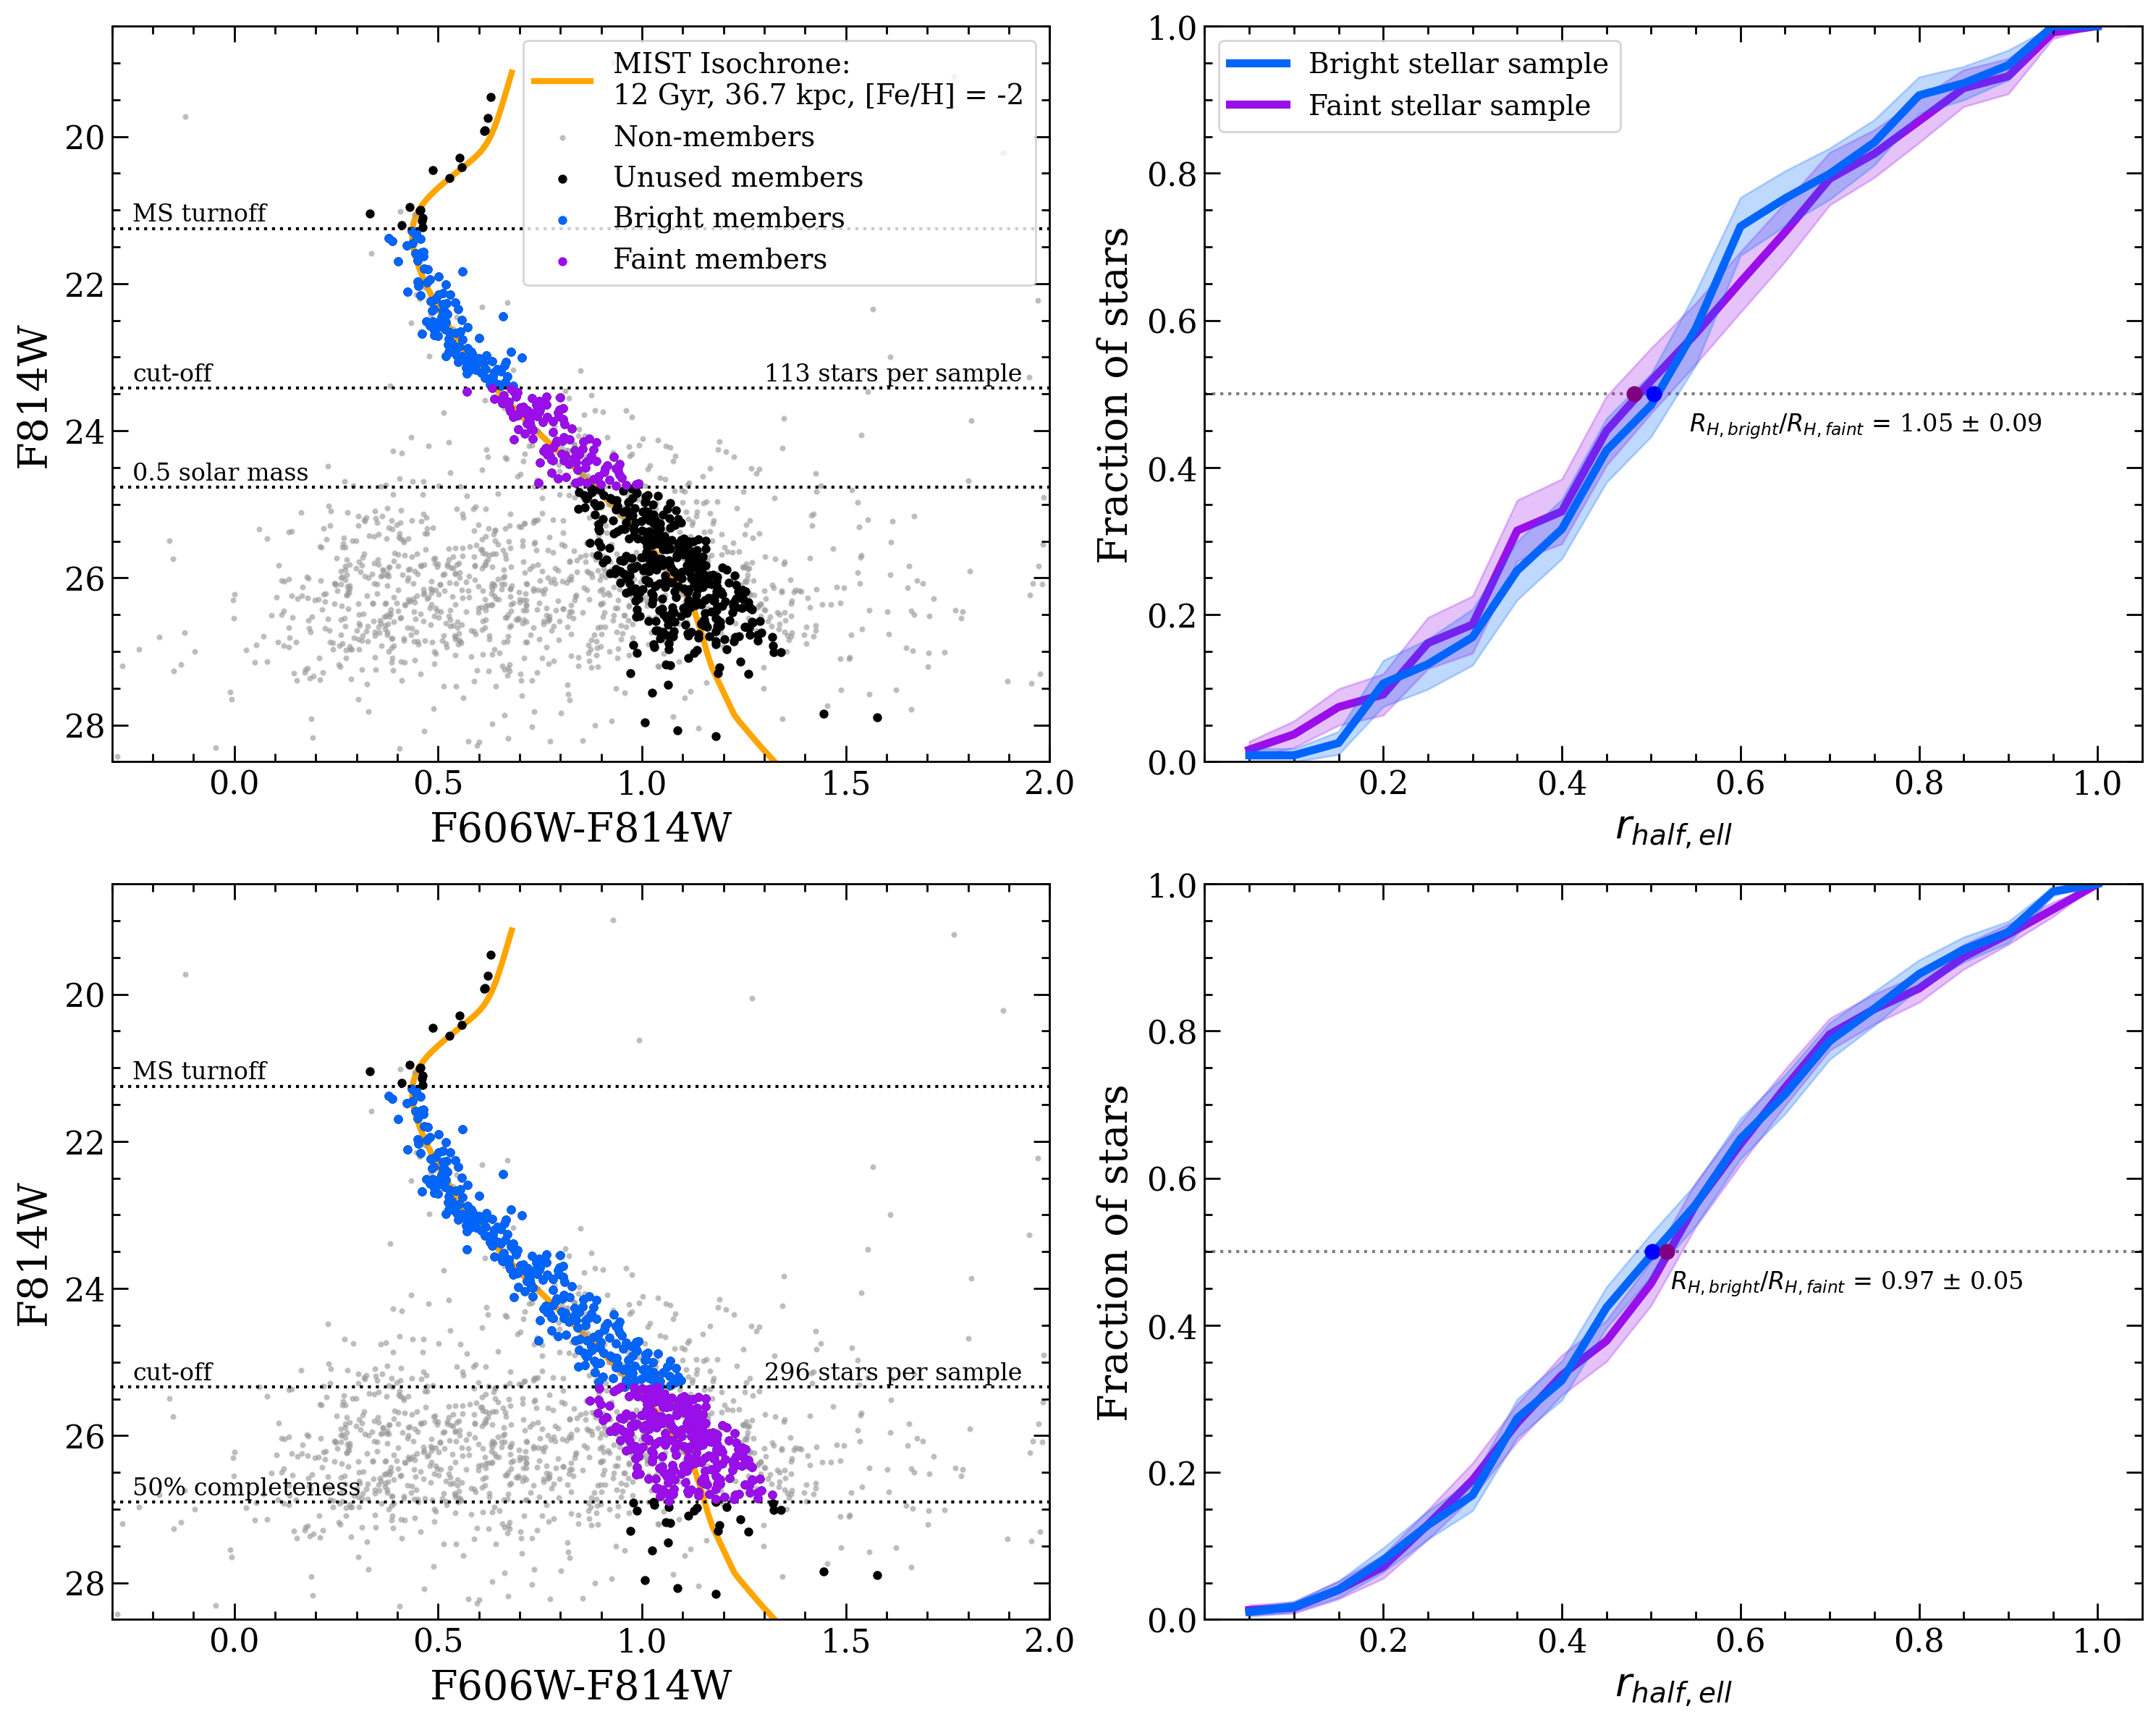

In [30]:
fig, axes = plt.subplots(2, 2, figsize = (15, 12), tight_layout = True)

### CMD PLOT 1
#axes[0][0].set_box_aspect(1.2)
axes[0][0].plot(mist_iso_data["color"], mist_iso_data["mag"], linewidth = 3, c = "orange", 
                zorder = 0, label = "MIST Isochrone: \n12 Gyr, 36.7 kpc, [Fe/H] = -2")

axes[0][0].scatter(hst_wil1_cut["VEGA_606"]-hst_wil1_cut["VEGA_814"], hst_wil1_cut["VEGA_814"], 
                   alpha = 0.5, c = "#999999", s = 4, zorder = 0, label = "Non-members",
                   rasterized = True)
axes[0][0].scatter(hst_tot["VEGA_606"]-hst_tot["VEGA_814"], hst_tot["VEGA_814"], 
                   alpha = 0.5, c = "#999999", s = 4, zorder = 0, rasterized = True)

axes[0][0].scatter(hst_mems["VEGA_606"]-hst_mems["VEGA_814"], hst_mems["VEGA_814"], 
                   c = "black", s = 12, zorder = 1, label = "Unused members", rasterized = True)
axes[0][0].scatter(bright_mem1["VEGA_606"]-bright_mem1["VEGA_814"], bright_mem1["VEGA_814"], 
                   c = "#0165fc", s = 12, zorder = 2, label = "Bright members", rasterized = True)
axes[0][0].scatter(faint_mem1["VEGA_606"]-faint_mem1["VEGA_814"], faint_mem1["VEGA_814"], 
                   c = "#9a0eea", s = 12, zorder = 3, label = "Faint members", rasterized = True)

axes[0][0].axhline(ms_turnoff, linestyle = ":", c = "black")
axes[0][0].text(-0.25, ms_turnoff-0.1, 'MS turnoff', fontsize = 12)

axes[0][0].axhline(mag_cutoff1, linestyle = ":", c = "black")
axes[0][0].text(-0.25, mag_cutoff1-0.1, 'cut-off', fontsize = 12)
num_stars = str(len(bright_mem1)) + " stars per sample"
axes[0][0].text(1.3, mag_cutoff1-0.1, num_stars, fontsize = 12)

axes[0][0].axhline(phys_cutoff, linestyle = ":", c = "black")
axes[0][0].text(-0.25, phys_cutoff-0.1, '0.5 solar mass', fontsize = 12)

#axes[0][0].axhline(comp_50, linestyle = ":", c = "black")
#axes[0][0].text(-0.25, comp_50-0.1, '50% completeness')

#axes[0][0].axhline(comp_90, linestyle = ":", c = "black")
#axes[0][0].text(-0.25, comp_90-0.1, '90% completeness')

axes[0][0].set_xlabel("F606W-F814W", labelpad = 5, size = 20).set_color('black')
axes[0][0].set_ylabel("F814W", labelpad = 5, size = 20).set_color('black')

axes[0][0].set_xticks(np.arange(-0.5, 2.5, 0.5), minor = False)
axes[0][0].set_xticks(np.arange(-0.7, 2.1, 0.1), minor = True)
axes[0][0].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 16, color = "black", top = True)
axes[0][0].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

axes[0][0].set_yticks(np.arange(18, 32, 2), minor = False)
axes[0][0].set_yticks(np.arange(18, 29.5, 0.5), minor = True)
axes[0][0].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 16, color = "black", right = True)
axes[0][0].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

axes[0][0].set_xlim(-0.3, 2)
axes[0][0].set_ylim(28.5, 18.5)

axes[0][0].legend(loc = 'upper right', fontsize = 14, frameon = True)

### MASS SEG PLOT 1
axes[0][1].fill_between(bootstrap_df1["r_half"], lower_bound_bright1, upper_bound_bright1, 
                        alpha=0.25, zorder = 2, color = "#0165fc")
axes[0][1].plot(bootstrap_df1["r_half"], bootstrap_df1["bright_percent_avg"], c = "#0165fc", 
                linewidth=4, zorder = 2, label = "Bright stellar sample")

axes[0][1].fill_between(bootstrap_df1["r_half"], lower_bound_faint1, upper_bound_faint1, 
                        alpha=0.25, zorder = 1, color = "#9a0eea")
axes[0][1].plot(bootstrap_df1["r_half"], bootstrap_df1["faint_percent_avg"], c = "#9a0eea", 
                linewidth=4, zorder = 1, label = "Faint stellar sample")

axes[0][1].axhline(0.5, c = "black", alpha = 0.5, linestyle = ":", zorder = 0)
axes[0][1].scatter(np.mean(bright_hlr1), 0.5, c = "blue", s = 48, zorder = 3)
axes[0][1].scatter(np.mean(faint_hlr1), 0.5, c = "purple", s = 48, zorder = 3)

mass_seg1 = r"$R_{H, bright} / R_{H, faint}$ = " + str(round(np.mean(ratio1), 2)) + r" $\pm$ " + str(round(np.std(ratio1), 2))
axes[0][1].text(np.mean(bright_hlr1) + 0.04, 0.5 - 0.05, mass_seg1, fontsize = 12)

axes[0][1].set_xlabel(r"$r_{half, ell}$", labelpad = 5, size = 20).set_color('black')
axes[0][1].set_ylabel("Fraction of stars", labelpad = 5, size = 20).set_color('black')

axes[0][1].set_xticks(np.arange(0.2, 1.2, 0.2), minor = False)
axes[0][1].set_xticks(np.arange(0, 1.05, 0.05), minor = True)
axes[0][1].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 16, color = "black", top = True)
axes[0][1].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

axes[0][1].set_yticks(np.arange(0, 1.2, 0.2), minor = False)
axes[0][1].set_yticks(np.arange(0, 1.05, 0.05), minor = True)
axes[0][1].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 16, color = "black", right = True)
axes[0][1].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

axes[0][1].set_xlim(0, 1.05)
axes[0][1].set_ylim(0, 1)

axes[0][1].legend(loc = 'upper left', fontsize = 14, frameon = True)

### CMD PLOT 2
axes[1][0].plot(mist_iso_data["color"], mist_iso_data["mag"], linewidth = 3, 
                c = "orange", zorder = 0, label = "MIST Isochrone: \n12 Gyr, 38 kpc, [Fe/H] = -2")

axes[1][0].scatter(hst_wil1_cut["VEGA_606"]-hst_wil1_cut["VEGA_814"], hst_wil1_cut["VEGA_814"], 
                   alpha = 0.25, c = "#999999", s = 4, zorder = 0, label = "Non-members", rasterized = True)
axes[1][0].scatter(hst_tot["VEGA_606"]-hst_tot["VEGA_814"], hst_tot["VEGA_814"], 
                   alpha = 0.5, c = "#999999", s = 4, zorder = 0, rasterized = True)

axes[1][0].scatter(hst_mems["VEGA_606"]-hst_mems["VEGA_814"], hst_mems["VEGA_814"], 
                   c = "black", s = 12, zorder = 1, label = "Unused members", rasterized = True)
axes[1][0].scatter(bright_mem2["VEGA_606"]-bright_mem2["VEGA_814"], bright_mem2["VEGA_814"], 
                   c = "#0165fc", s = 12, zorder = 2, label = "Bright members", rasterized = True)
axes[1][0].scatter(faint_mem2["VEGA_606"]-faint_mem2["VEGA_814"], faint_mem2["VEGA_814"], 
                   c = "#9a0eea", s = 12, zorder = 3, label = "Faint members", rasterized = True)

axes[1][0].axhline(ms_turnoff, linestyle = ":", c = "black")
axes[1][0].text(-0.25, ms_turnoff-0.1, 'MS turnoff', fontsize = 12)

axes[1][0].axhline(mag_cutoff2, linestyle = ":", c = "black")
axes[1][0].text(-0.25, mag_cutoff2-0.1, 'cut-off', fontsize = 12)
num_stars2 = str(len(bright_mem2)) + " stars per sample"
axes[1][0].text(1.3, mag_cutoff2-0.1, num_stars2, fontsize = 12)

#axes[1][0].axhline(phys_cutoff, linestyle = ":", c = "black")
#axes[1][0].text(-0.25, phys_cutoff-0.1, '0.5 solar mass')

axes[1][0].axhline(comp_50, linestyle = ":", c = "black")
axes[1][0].text(-0.25, comp_50-0.1, '50% completeness', fontsize = 12)

# axes[1][0].axhline(comp_90, linestyle = ":", c = "black")
# axes[1][0].text(-0.25, comp_90-0.1, '90% completeness', fontsize = 12)

axes[1][0].set_xlabel("F606W-F814W", labelpad = 5, size = 20).set_color('black')
axes[1][0].set_ylabel("F814W", labelpad = 5, size = 20).set_color('black')

axes[1][0].set_xticks(np.arange(-0.5, 2.5, 0.5), minor = False)
axes[1][0].set_xticks(np.arange(-0.7, 2.1, 0.1), minor = True)
axes[1][0].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 16, color = "black", top = True)
axes[1][0].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

axes[1][0].set_yticks(np.arange(18, 32, 2), minor = False)
axes[1][0].set_yticks(np.arange(18, 29.5, 0.5), minor = True)
axes[1][0].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 16, color = "black", right = True)
axes[1][0].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

axes[1][0].set_xlim(-0.3, 2)
axes[1][0].set_ylim(28.5, 18.5)

### MASS SEG PLOT 2
axes[1][1].fill_between(bootstrap_df2["r_half"], lower_bound_bright2, upper_bound_bright2, 
                        alpha=0.25, zorder = 2, color = "#0165fc")
axes[1][1].plot(bootstrap_df2["r_half"], bootstrap_df2["bright_percent_avg"], c = "#0165fc", 
                linewidth=4, zorder = 2, label = "Bright stellar sample")

axes[1][1].fill_between(bootstrap_df2["r_half"], lower_bound_faint2, upper_bound_faint2, 
                        alpha=0.25, zorder = 1, color = "#9a0eea")
axes[1][1].plot(bootstrap_df2["r_half"], bootstrap_df2["faint_percent_avg"], c = "#9a0eea", 
                linewidth=4, zorder = 1, label = "Faint stellar sample")

axes[1][1].axhline(0.5, c = "black", alpha = 0.5, linestyle = ":", zorder = 0)
axes[1][1].scatter(np.mean(bright_hlr2), 0.5, c = "blue", s = 48, zorder = 3)
axes[1][1].scatter(np.mean(faint_hlr2), 0.5, c = "purple", s = 48, zorder = 3)

mass_seg2 = r"$R_{H, bright} / R_{H, faint}$ = " + str(round(np.mean(ratio2), 2)) + r" $\pm$ " + str(round(np.std(ratio2), 2))
axes[1][1].text(np.mean(bright_hlr2) + 0.02, 0.5 - 0.05, mass_seg2, fontsize = 12)

axes[1][1].set_xlabel(r"$r_{half, ell}$", labelpad = 5, size = 20).set_color('black')
axes[1][1].set_ylabel("Fraction of stars", labelpad = 5, size = 20).set_color('black')

axes[1][1].set_xticks(np.arange(0.2, 1.2, 0.2), minor = False)
axes[1][1].set_xticks(np.arange(0, 1.05, 0.05), minor = True)
axes[1][1].tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 16, color = "black", top = True)
axes[1][1].tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

axes[1][1].set_yticks(np.arange(0, 1.2, 0.2), minor = False)
axes[1][1].set_yticks(np.arange(0, 1.05, 0.05), minor = True)
axes[1][1].tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 16, color = "black", right = True)
axes[1][1].tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

axes[1][1].set_xlim(0, 1.05)
axes[1][1].set_ylim(0, 1)

fig.savefig("plots/6_mass_seg.pdf", dpi = 600, transparent = True)

## Luminosity function HST

In [168]:
full_inner = hst_wil1_cut[(hst_wil1_cut["hl_radius_ell"] < 0.5) & (hst_wil1_cut["VEGA_814"] > ms_turnoff)]
full_outer = hst_wil1_cut[(hst_wil1_cut["hl_radius_ell"] > 0.5) & (hst_wil1_cut["VEGA_814"] > ms_turnoff)]
print(len(full_inner), len(full_outer))

294 325


In [169]:
hist_inner, bin_edges = np.histogram(full_inner["VEGA_814"], bins = np.arange(20, 28, 0.5))
hist_outer, bin_edges = np.histogram(full_outer["VEGA_814"], bins = np.arange(20, 28, 0.5))
bins = np.delete(bin_edges, [-1]) + 0.25

/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/438379742.py:6: RuntimeWarning: divide by zero encountered in log
  ax.scatter(bins, np.log(hist_inner) + offset, linewidth = 2, label = "Central stars (rhalf < 0.5)")
/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/438379742.py:7: RuntimeWarning: divide by zero encountered in log
  ax.plot(bins, np.log(hist_inner) + offset, linewidth = 2)
/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/438379742.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(bins, np.log(hist_outer), linewidth = 2, label = "Tail stars (rhalf > 0.5)")
/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/438379742.py:10: RuntimeWarning: divide by zero encountered in log
  ax.plot(bins, np.log(hist_outer), linewidth = 2)


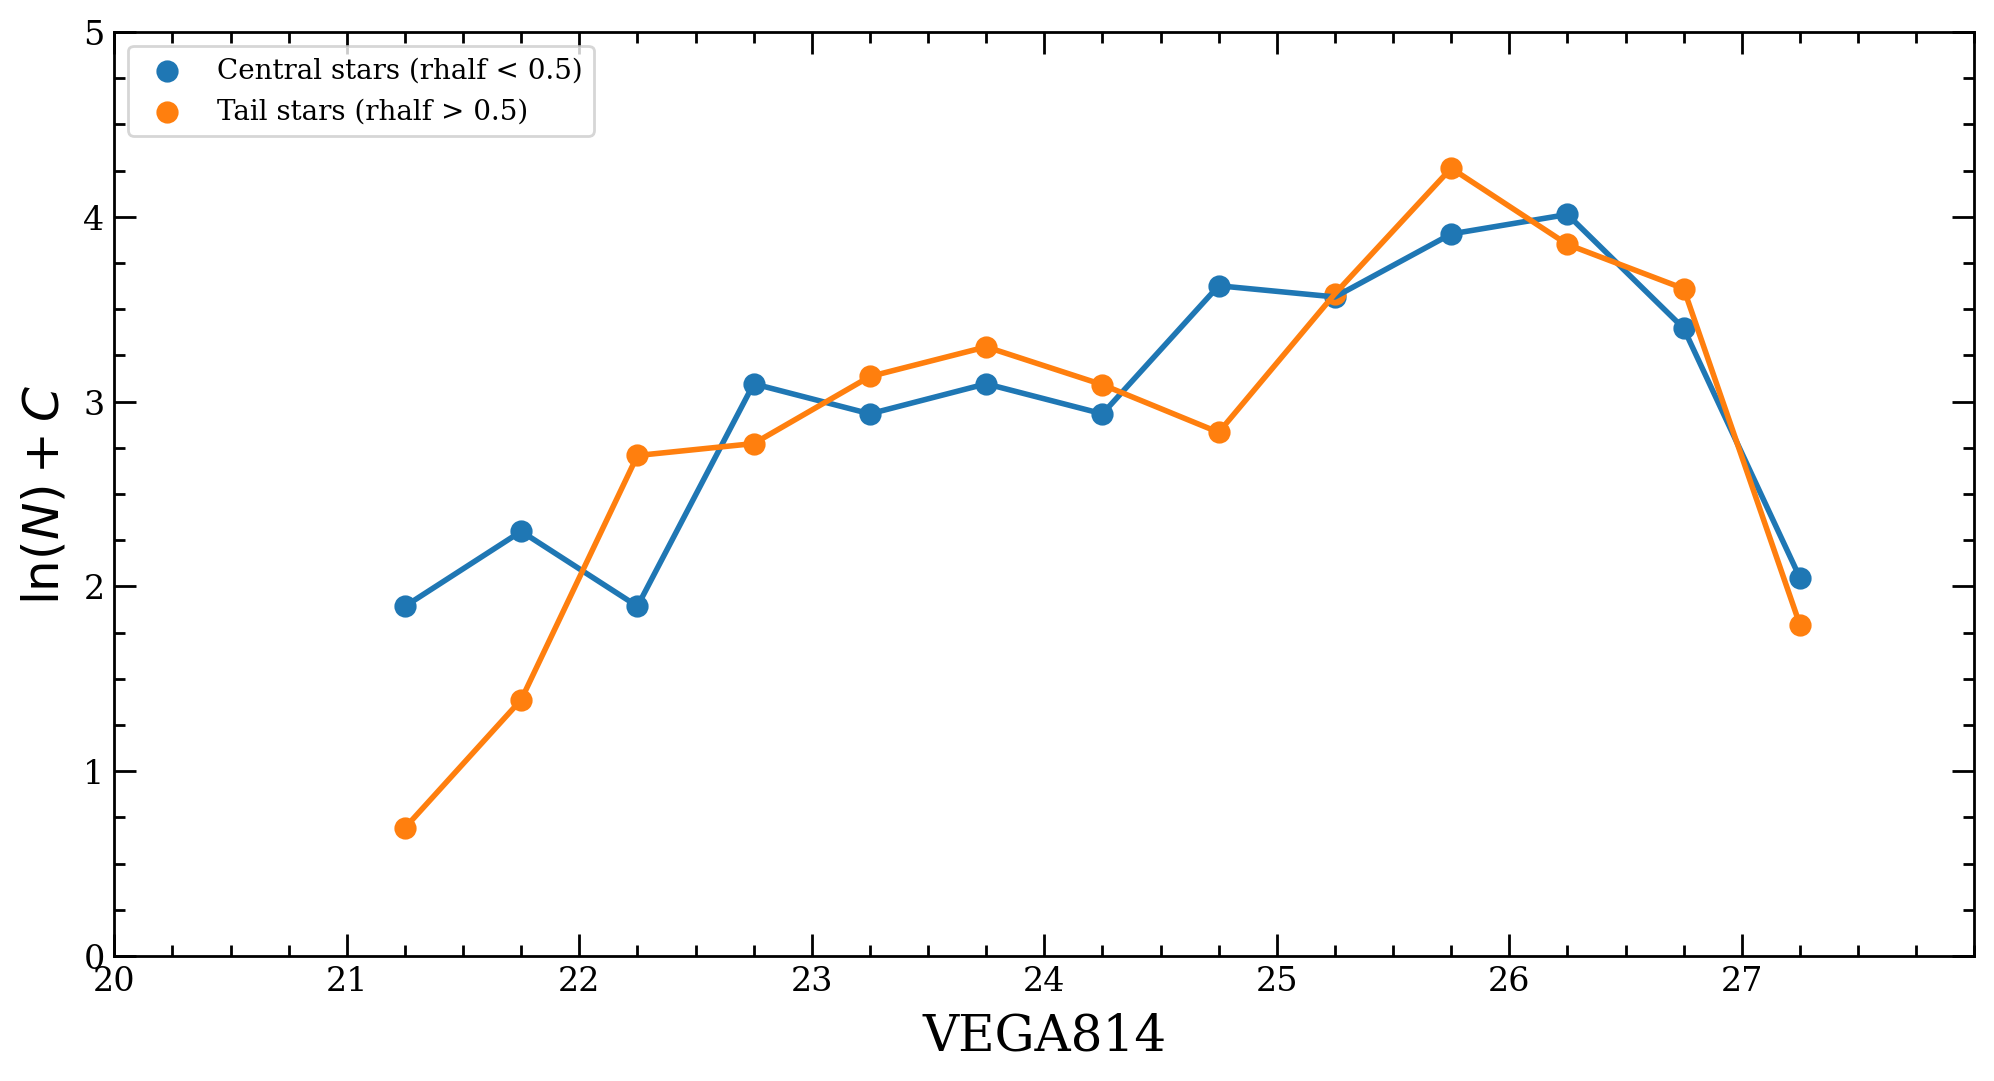

In [170]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()

offset = np.log(len(full_outer)) - np.log(len(full_inner))

ax.scatter(bins, np.log(hist_inner) + offset, linewidth = 2, label = "Central stars (rhalf < 0.5)")
ax.plot(bins, np.log(hist_inner) + offset, linewidth = 2)

ax.scatter(bins, np.log(hist_outer), linewidth = 2, label = "Tail stars (rhalf > 0.5)")
ax.plot(bins, np.log(hist_outer), linewidth = 2)

ax.set_xlabel(r'VEGA814', labelpad = 5, size = 18).set_color('black')
ax.set_ylabel(r'$\ln(N) + C$', labelpad = 5, size = 18).set_color('black')

ax.set_xticks(np.arange(20, 28, 1), minor = False)
ax.set_xticks(np.arange(20, 28.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(0, 6, 1), minor = False)
ax.set_yticks(np.arange(0, 5.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.set_xlim(20, 28)
ax.set_ylim(0, 5)

ax.legend(loc = "upper left", fontsize = 10, frameon = True)

# fig.savefig("luminosity_function_hst.pdf", dpi = 600, transparent = True)

In [171]:
stat, pvalue = scipy.stats.ks_2samp(np.log(hist_inner) + offset, np.log(hist_outer))
print(pvalue, 100*(1-pvalue))

0.9383310279844598 6.166897201554022


/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/1265638225.py:1: RuntimeWarning: divide by zero encountered in log
  stat, pvalue = scipy.stats.ks_2samp(np.log(hist_inner) + offset, np.log(hist_outer))


## Luminosity function

In [172]:
deimos_data = pd.read_csv("data/dmost_cutdata_evaluated.csv", index_col = 0)

In [173]:
full_inner = deimos_data[(deimos_data["sample"] == 1) & (deimos_data["hl_radius_ell"] <= 1)]
full_outer = deimos_data[(deimos_data["sample"] == 1) & (deimos_data["hl_radius_ell"] > 1)]
print(len(full_inner), len(full_outer))

28 28


In [174]:
hist_inner, bin_edges = np.histogram(full_inner["rmag_o"], bins = np.arange(18, 24, 0.5))
hist_outer, bin_edges = np.histogram(full_outer["rmag_o"], bins = np.arange(18, 24, 0.5))
bins = np.delete(bin_edges, [-1]) + 0.25

/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/2556795868.py:6: RuntimeWarning: divide by zero encountered in log
  ax.scatter(bins, np.log(hist_inner) + offset, linewidth = 2, label = "Central stars (rhalf < 1)")
/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/2556795868.py:7: RuntimeWarning: divide by zero encountered in log
  ax.plot(bins, np.log(hist_inner) + offset, linewidth = 2)
/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/2556795868.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(bins, np.log(hist_outer), linewidth = 2, label = "Tail stars (rhalf > 1)")
/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/2556795868.py:10: RuntimeWarning: divide by zero encountered in log
  ax.plot(bins, np.log(hist_outer), linewidth = 2)


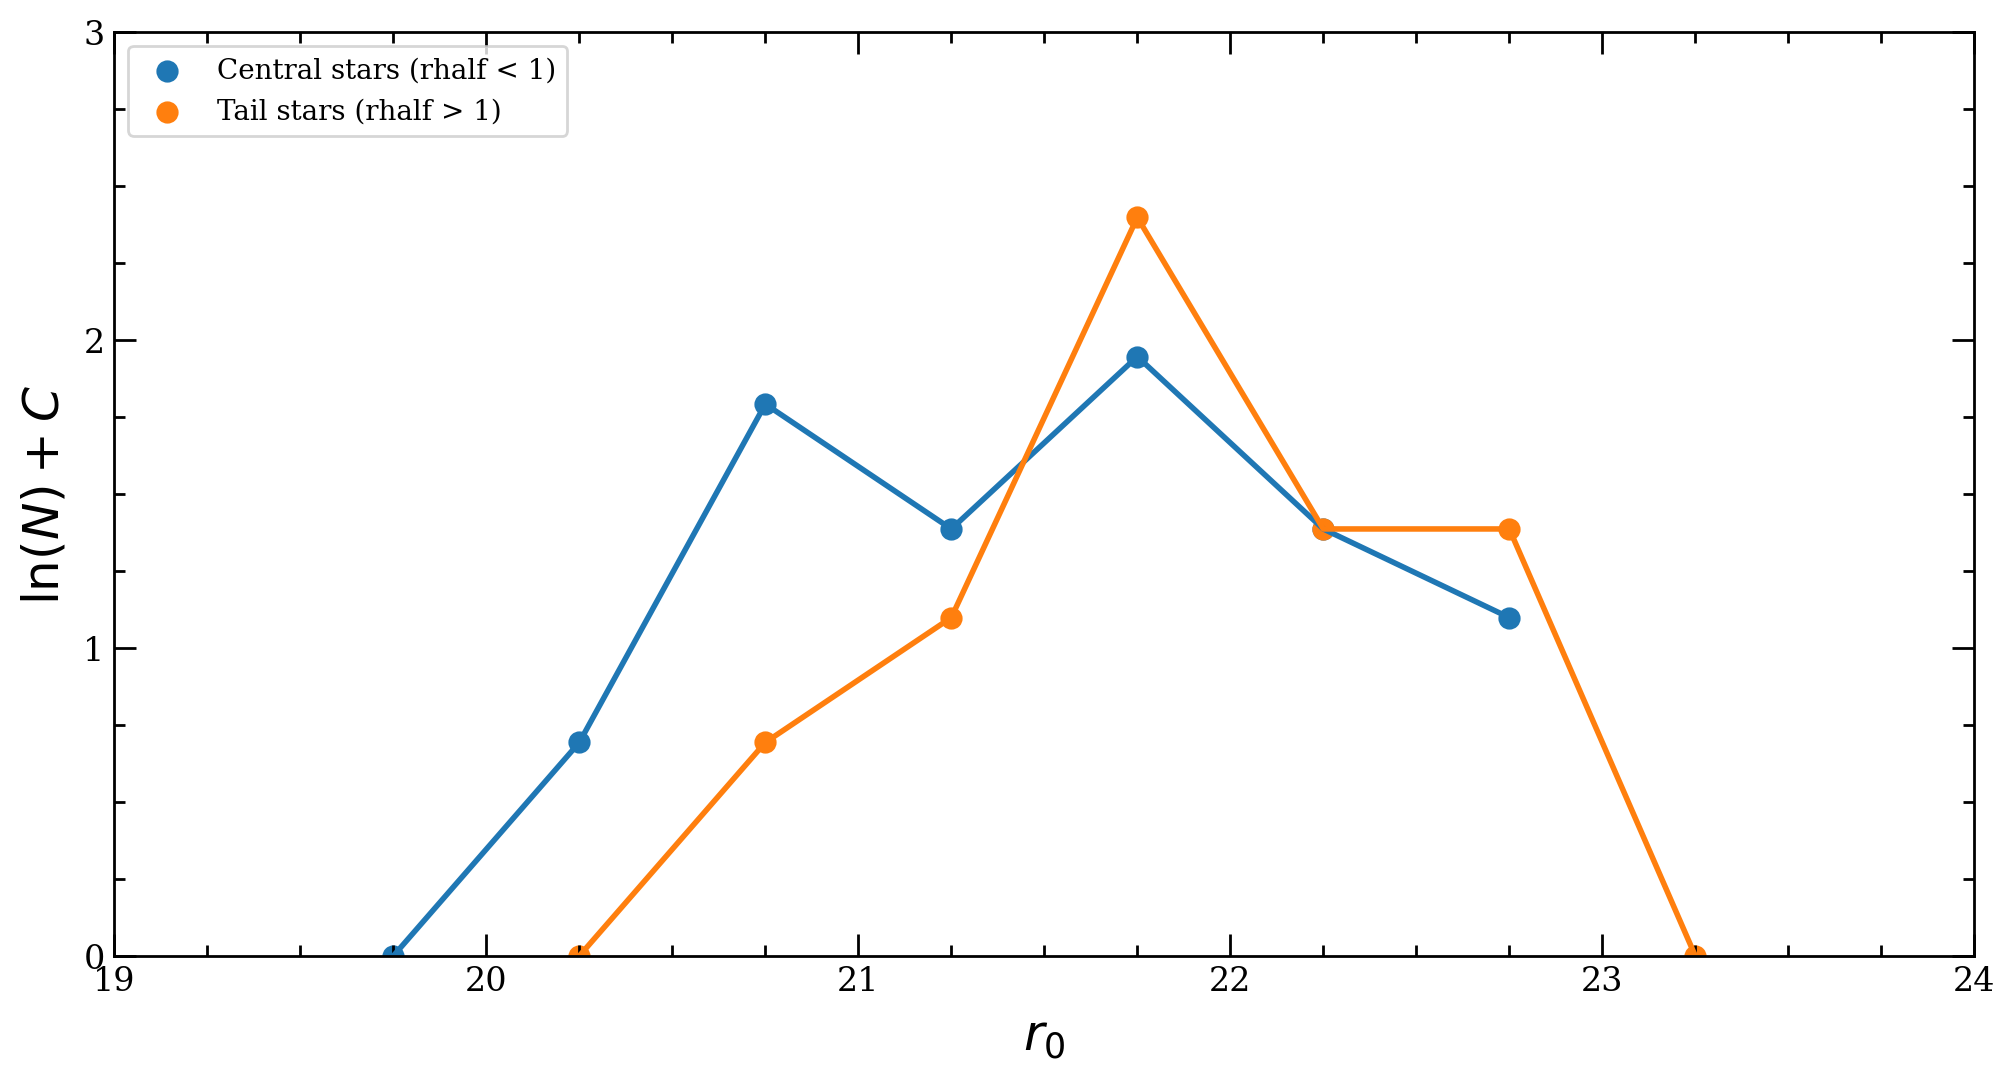

In [175]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()

offset = np.log(len(full_outer)) - np.log(len(full_inner))

ax.scatter(bins, np.log(hist_inner) + offset, linewidth = 2, label = "Central stars (rhalf < 1)")
ax.plot(bins, np.log(hist_inner) + offset, linewidth = 2)

ax.scatter(bins, np.log(hist_outer), linewidth = 2, label = "Tail stars (rhalf > 1)")
ax.plot(bins, np.log(hist_outer), linewidth = 2)

ax.set_xlabel(r'$r_0$', labelpad = 5, size = 18).set_color('black')
ax.set_ylabel(r'$\ln(N) + C$', labelpad = 5, size = 18).set_color('black')

ax.set_xticks(np.arange(18, 25, 1), minor = False)
ax.set_xticks(np.arange(18, 24.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(0, 5, 1), minor = False)
ax.set_yticks(np.arange(0, 4.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.set_xlim(19, 24)
ax.set_ylim(0, 3)

ax.legend(loc = "upper left", fontsize = 10, frameon = True)

# fig.savefig("luminosity_function_deimos.pdf", dpi = 600, transparent = True)

In [176]:
stat, pvalue = scipy.stats.ks_2samp(np.log(hist_inner) + offset, np.log(hist_outer))
print(pvalue, 100*(1-pvalue))

0.9999999999999999 1.1102230246251565e-14


/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_15021/1265638225.py:1: RuntimeWarning: divide by zero encountered in log
  stat, pvalue = scipy.stats.ks_2samp(np.log(hist_inner) + offset, np.log(hist_outer))
